#import libraries

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import time
import copy
from glob import glob
import imageio

#Download Intel Image Dataset

In [32]:
# from google.colab import drive

# drive.mount('/content/gdrive/', force_remount=True)

#Data directory set

In [33]:
#!unzip gdrive/MyDrive/intel-image-classification.zip

In [34]:
train_data = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_data = '/kaggle/input/intel-image-classification/seg_test/seg_test'

#Data Augmentation

In [35]:
train_transformers = [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5),#change
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
test_transformers = [
        transforms.RandomResizedCrop(224),#change
        transforms.CenterCrop(224),#change
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]
data_transforms = {
    train_data: transforms.Compose(train_transformers),
    test_data: transforms.Compose(test_transformers),
}

In [36]:

our_datasets = {x: datasets.ImageFolder(os.path.join(x), data_transforms[x]) for x in [train_data, test_data]}

dataloader = {x: torch.utils.data.DataLoader(our_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in [train_data, test_data]}

dataset_sizes = {x: len(our_datasets[x]) for  x in [train_data,test_data]}

class_names = our_datasets[train_data].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [37]:
model = models.resnet101(pretrained=True)

In [38]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

show_transformed_images(image_datasets[train])

In [39]:
for param in model.parameters():
    param.requires_grad = False

In [40]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [42]:
model.fc = nn.Sequential(nn.Linear(2048, 512),
                          nn.ReLU(),
                          nn.Dropout(0.3),
                          nn.Linear(512, 6),
                         nn.LogSoftmax(dim=1))

model = model.to(device)


In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,6], gamma=0.06)

In [44]:
from datetime import datetime

In [45]:
def train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in dataloader[train_data]:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        scheduler.step()

        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in dataloader[test_data]:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        
        print(f'Epoch {it+1}/{epochs}, Train_Loss: {train_loss:.4f}, \Test_Loss: {test_loss:.4f}, Duration: {dt} ')
        
    return train_losses, test_losses

In [46]:
train_losses, test_losses = train_model(
                            model,
                            criterion,
                            optimizer,
                            scheduler,
                            dataloader[train_data],
                            dataloader[test_data],
                            epochs=15)

Epoch 1/15, Train_Loss: 0.5412, \Test_Loss: 0.4369, Duration: 0:01:26.599378 
Epoch 2/15, Train_Loss: 0.4463, \Test_Loss: 0.3931, Duration: 0:01:03.036770 
Epoch 3/15, Train_Loss: 0.4239, \Test_Loss: 0.3982, Duration: 0:01:03.687471 
Epoch 4/15, Train_Loss: 0.4197, \Test_Loss: 0.4164, Duration: 0:01:04.027120 
Epoch 5/15, Train_Loss: 0.3638, \Test_Loss: 0.3689, Duration: 0:01:03.341159 
Epoch 6/15, Train_Loss: 0.3582, \Test_Loss: 0.3772, Duration: 0:01:02.295365 
Epoch 7/15, Train_Loss: 0.3552, \Test_Loss: 0.3620, Duration: 0:01:03.063156 
Epoch 8/15, Train_Loss: 0.3438, \Test_Loss: 0.3402, Duration: 0:01:02.628086 
Epoch 9/15, Train_Loss: 0.3536, \Test_Loss: 0.3611, Duration: 0:01:02.715464 
Epoch 10/15, Train_Loss: 0.3534, \Test_Loss: 0.3535, Duration: 0:01:02.801739 
Epoch 11/15, Train_Loss: 0.3562, \Test_Loss: 0.3628, Duration: 0:01:02.848723 
Epoch 12/15, Train_Loss: 0.3508, \Test_Loss: 0.3625, Duration: 0:01:02.725316 
Epoch 13/15, Train_Loss: 0.3518, \Test_Loss: 0.3622, Duration

In [49]:
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_losses, test_losses = train_model(
                            model,
                            criterion,
                            optimizer,
                            scheduler,
                            dataloader[train_data],
                            dataloader[test_data],
                            epochs=20)

Epoch 1/20, Train_Loss: 0.4166, \Test_Loss: 0.3553, Duration: 0:02:14.053874 
Epoch 2/20, Train_Loss: 0.3436, \Test_Loss: 0.3479, Duration: 0:02:13.717146 
Epoch 3/20, Train_Loss: 0.3059, \Test_Loss: 0.3010, Duration: 0:02:14.239600 
Epoch 4/20, Train_Loss: 0.2909, \Test_Loss: 0.3222, Duration: 0:02:14.008523 
Epoch 5/20, Train_Loss: 0.2848, \Test_Loss: 0.3155, Duration: 0:02:14.032070 
Epoch 6/20, Train_Loss: 0.2771, \Test_Loss: 0.3269, Duration: 0:02:14.246331 
Epoch 7/20, Train_Loss: 0.2580, \Test_Loss: 0.3184, Duration: 0:02:14.074359 
Epoch 8/20, Train_Loss: 0.2537, \Test_Loss: 0.2983, Duration: 0:02:13.544388 
Epoch 9/20, Train_Loss: 0.2456, \Test_Loss: 0.2936, Duration: 0:02:13.395114 
Epoch 10/20, Train_Loss: 0.2395, \Test_Loss: 0.2927, Duration: 0:02:13.840111 
Epoch 11/20, Train_Loss: 0.2238, \Test_Loss: 0.3081, Duration: 0:02:14.077781 
Epoch 12/20, Train_Loss: 0.2287, \Test_Loss: 0.3221, Duration: 0:02:14.164778 
Epoch 13/20, Train_Loss: 0.2213, \Test_Loss: 0.3446, Duration

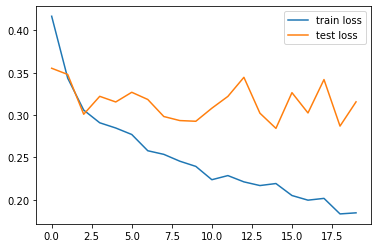

In [50]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [52]:
n_correct = 0
n_total = 0
for inputs, targets in dataloader[train_data]:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, -1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for inputs, targets in dataloader[test_data]:
  inputs, targets = inputs.to(device), targets.to(device)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, -1)
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]
test_acc = n_correct/n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.9422, Test acc: 0.8900


In [53]:
from tqdm.autonotebook import tqdm

In [54]:
train_losses=[]
test_losses=[]
def accuracy(loader, model):
    num_corrects = 0
    num_samples = 0
    model.eval()
    loop = tqdm(loader)
    with torch.no_grad():
        for x, y in loop:
            x = x.to(device)
            y = y.to(device)
            scores = model(x)
            test_losses.append(scores.data)
            _, prediction = scores.max(1)
            num_corrects += (prediction == y).sum()
            num_samples += prediction.size(0)
            acc = (num_corrects/num_samples) * 100
            loop.set_postfix(acc=acc.item())
        print(f'Got {num_corrects}/{num_samples} with accuracy {acc:.4f}')

In [55]:
accuracy(dataloader[test_data], model)

  0%|          | 0/94 [00:00<?, ?it/s]

Got 2689/3000 with accuracy 89.6333
